<header><font size="+2"> <center> <b> Solving the Ising model with the Metropolis Algorithm </b></center></font></header>

In [1]:
import numpy as np
import multiprocessing as mp
import itertools as it

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 6)

In [8]:
Tc = 2.269185


(I know these could be expressed as matrix ops, so far they're fast enough, though)

In [3]:
def p(ind, N):
    if ind == -1:
        return N - 1
    return ind % N

In [4]:
def energy(s, J=1):
    E = 0
    N = s.shape[0]

    for i in range(N):
        for j in range(N):
            dE = s[i, j] * (
                s[p(i+1, N), j] + s[p(i-1, N), j] 
                + s[i, p(j+1, N)] + s[i, p(j-1,N)]
            )
            E -= 0.5 * J * dE

    return E


In [182]:
def simulate(N, T, J = 1, niter = 5000):
    Es = []
    
    s = 2 * (np.random.uniform(size=(N, N)) > 0.5) - 1
    E = energy(s, J)
    
    Es.append(E)
    
    for itr in range(niter):
        indx = np.random.randint(0, N)
        indy = np.random.randint(0, N)
                
        dE = 2 * J * s[indy, indx] *  (  s[p(indy + 1, N), indx]\
                                       + s[p(indy - 1, N), indx]\
                                       + s[indy, p(indx - 1, N)]
                                       + s[indy, p(indx + 1, N)])
        
        # accept
        # don't need exp!
        if dE < 0 or np.random.rand() <= np.exp(-1 * (dE / T)):
            s[indy, indx] = s[indy, indx] * -1
            E = E + dE
            
            Es.append(E)
    
    return s #, Es

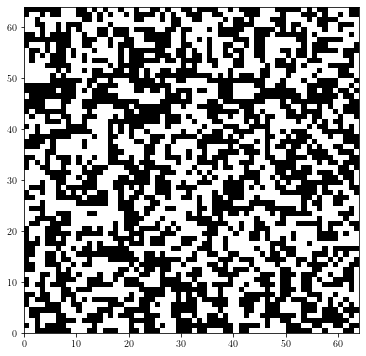

In [234]:
s  = simulate(64, 0.000001, J=0.00001, niter=N*N)
plt.pcolormesh(s, cmap="binary");

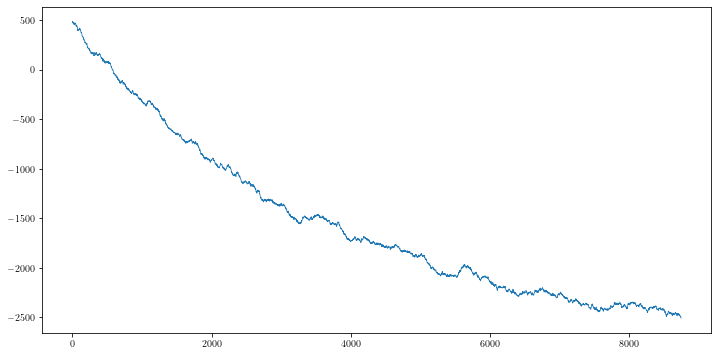

In [181]:
plt.plot(E);

In [132]:
energy(s, 1)

-2716.0

## Sanity check - magnetization

In [114]:
np.unique(s)

array([-1,  1])

In [195]:
m = []
msq = []
for T in np.linspace(0.1, 10, 20):
    s = simulate(32, T, niter=5000)
    m.append(s.mean())    
    msq.append(np.abs(s.mean())**2)

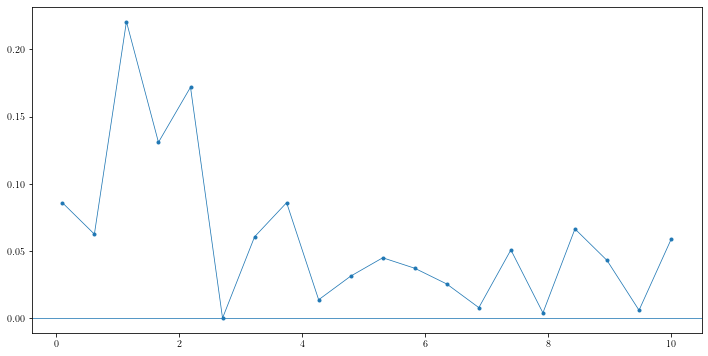

In [196]:
plt.plot(np.linspace(0.1, 10, 20), np.abs(m), marker='.');
plt.axhline(0);

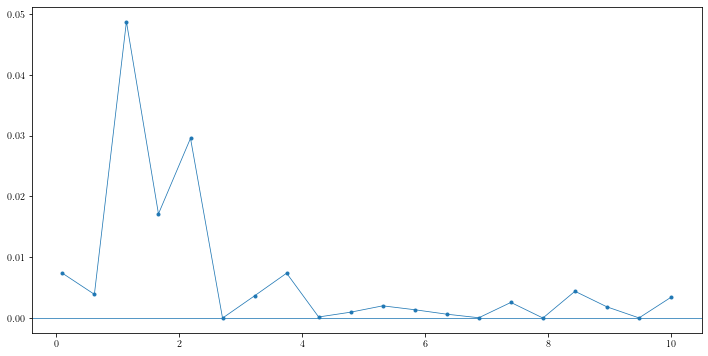

In [197]:
plt.plot(np.linspace(0.1, 10, 20), msq, marker='.');
plt.axhline(0);

In [143]:
E = []
for T in np.linspace(0.1, 10, 20):
    s = simulate(64, T, niter=10000)
    E.append(energy(s) / (N*N))    

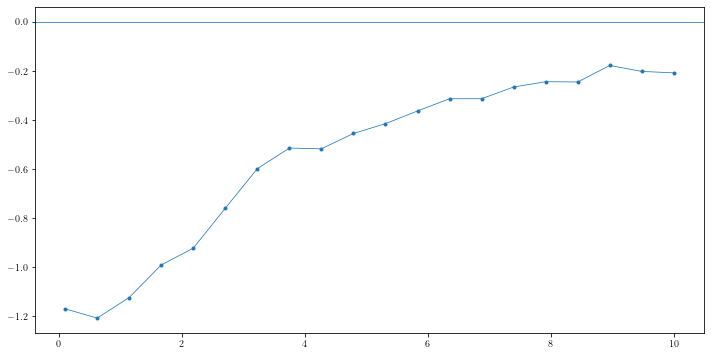

In [160]:
plt.plot(np.linspace(0.1, 10, 20), E, marker='.');
plt.axhline(0);

# Generate data for the GAN

In [164]:
pool = mp.Pool(mp.cpu_count() // 2)

In [198]:
Ndata = 1000

In [202]:
N = 64
T = 1
J = 10

  Generate Ndata **equilibrium** states at T

In [203]:
res = pool.starmap(simulate, it.repeat((N, T, J, 5000), Ndata))

Dump them concatenated  

In [204]:
np.array(res).tofile("mcdata/" + str(T) + ".dat")

In [205]:
pool.close()

# Use burn - in

In [40]:
def MCstep(s, N, E, T, J, nsteps):
    for itr in range(nsteps):
        indx = np.random.randint(0, N)
        indy = np.random.randint(0, N)

        dE = 2 * J * s[indy, indx] *  (  s[p(indy + 1, N), indx]\
                                       + s[p(indy - 1, N), indx]\
                                       + s[indy, p(indx - 1, N)]
                                       + s[indy, p(indx + 1, N)])

        # accept
        if (dE < 0) or np.random.rand() <= np.exp(-1 * (dE / T)):
            
            s[indy, indx] = s[indy, indx] * -1
            E = E + dE

    return s, E

def simulateBI(N, T, J = 1, burn_in = 3000, nsteps = 1000, n_outputs = 1000):
    ss = []
    Es = []
    Ms = []
    Mavgs = []
    
    # random init
    s = 2 * (np.random.uniform(size=(N, N)) > 0.5) - 1
    E = energy(s, J)

    # burn-in
    s, E = MCstep(s, N, E, T, J, nsteps = burn_in)
    
    #explore equlibrium state    
    for itr in range(n_outputs):     
        s = np.copy(s)
        ss.append(s)
        Es.append(E)
        Ms.append(np.sum(s))
        Mavgs.append(np.mean(s))
        
        s, E = MCstep(s, N, E, T, J, nsteps = nsteps)
    
    return ss, Es, Ms, Mavgs 

In [73]:
ss, Es, Ms, Mavgs = simulateBI(64, T=1, J=1, burn_in = 10000, nsteps = 1000, n_outputs=2000)

In [74]:
np.all(ss[0] == ss[-1])

False

In [67]:
np.array(ss).tofile("mcdata/new_64_" + str(1) + ".dat")

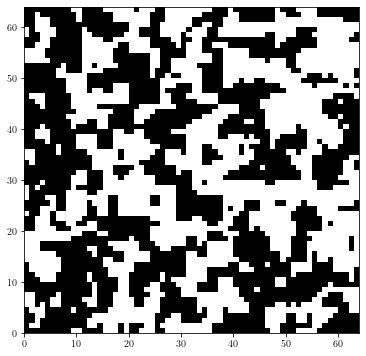

In [75]:
plt.pcolormesh(ss[0], cmap="binary");

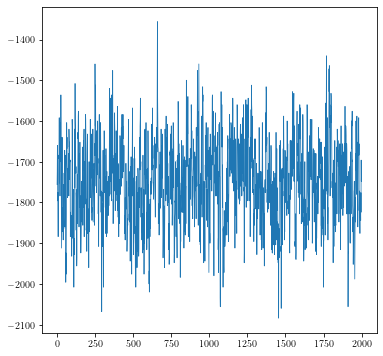

In [63]:
plt.plot(Es)

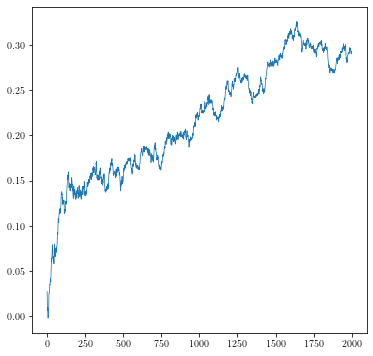

In [71]:
plt.plot(Mavgs);

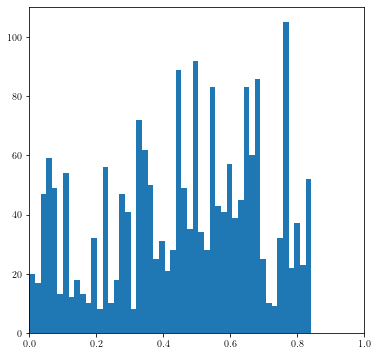

In [76]:
plt.hist(np.abs(Mavgs), bins=50);
plt.xlim(0, 1);